## Baseline model for species classification: PCA + SVM

In [1]:
#import sklearn modules
from sklearn.cross_validation import train_test_split
from sklearn.datasets import fetch_lfw_people
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import RandomizedPCA
from sklearn.svm import SVC

#import miscellaneous module
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import logging
import matplotlib.pyplot as plt
from PIL import Image
from time import time




/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
#define some necessary functions

#function to remove .DS_Store files that autogenerate in every new folder on my mac
def banish_DS_Store(li):
    if '.DS_Store' in li:
        li.remove('.DS_Store')
    return li

In [3]:
#read in train data
species_path = '../not-so-random-forest/data/classification/'
X_train = []
y_train = []
count = 0
train_folders = banish_DS_Store(os.listdir(species_path + '/train/'))
for folder in train_folders:
    files = banish_DS_Store(os.listdir(species_path + '/train/' + folder))
    for file in files:
        # converting image to grayscale
        img = Image.open(species_path + '/train/' + folder + '/' + file).convert('L')
            
        #reshape image to (224, 224)
        img = img.resize((224, 224), Image.ANTIALIAS)
        X_train.append(np.array(img))
        y_train.append(count)
    count = count + 1

X_train = np.array(X_train)
y_train = np.array(y_train)

#reshape images to to shape (n_images, n_features)
X_train = np.reshape(X_train, (X_train.shape[0], 224*224))

print(X_train.shape)
print(y_train.shape)

(1562, 50176)
(1562,)


In [4]:
#read in test data
species_path = '../not-so-random-forest/data/classification/'
X_test = []
y_test = []
count = 0
train_folders = banish_DS_Store(os.listdir(species_path + '/validate/'))
for folder in train_folders:
    files = banish_DS_Store(os.listdir(species_path + '/validate/' + folder))
    for file in files:
        # converting image to grayscale
        img = Image.open(species_path + '/validate/' + folder + '/' + file).convert('L')
            
        #reshape image to (224, 224)
        img = img.resize((224, 224), Image.ANTIALIAS)
        X_test.append(np.array(img))
        y_test.append(count)
    count = count + 1

X_test = np.array(X_test)
y_test = np.array(y_test)

#reshape images to shape (n_images, n_features)
X_test = np.reshape(X_test, (X_test.shape[0], 224*224))

print(X_test.shape)
print(y_test.shape)

(378, 50176)
(378,)


In [5]:
#select number of components
n_components = 100
print("Extracting the top %d eigentrees from %d trees" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 100 eigentrees from 1562 trees


/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 1.706s


(0, 0.2)

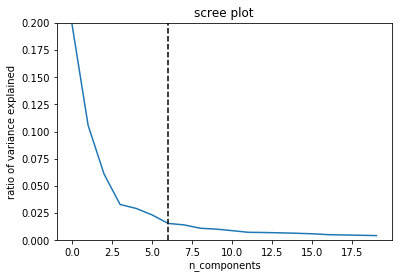

In [6]:
#variance explained
plt.plot(pca.explained_variance_ratio_[0:20])
plt.title('scree plot')
plt.xlabel('n_components')
plt.ylabel('ratio of variance explained')
plt.plot([6 ,6], [-0.1 ,0.3], 'k--')
plt.ylim([0,0.2])

In [7]:
#setting n_components to 6 based on knee in scree plot that occurs at n_components=6
n_components = 6
print("Extracting the top %d eigentrees from %d trees" % (n_components, X_train.shape[0]))
t0 = time()
pca = RandomizedPCA(n_components=n_components, whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

Extracting the top 6 eigentrees from 1562 trees


/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


done in 0.831s


In [8]:
#project tree images onto eigentrees
eigentrees = pca.components_.reshape((n_components, 224, 224))
print("Projecting the input data on the eigentree orthonormal basis")
print(eigentrees.shape)
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))
print(X_train_pca.shape)
print(X_test_pca.shape)

Projecting the input data on the eigentree orthonormal basis
(6, 224, 224)
done in 0.284s
(1562, 6)
(378, 6)


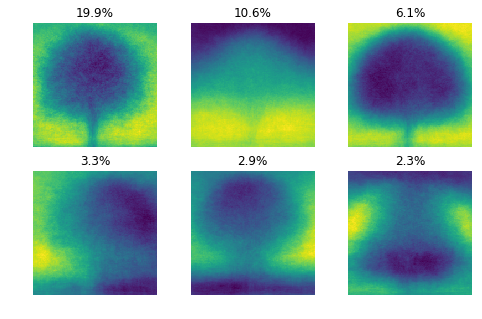

In [9]:
#visualize eigentrees
h = 80
w = 80
fig=plt.figure(figsize=(8, 5))
columns = 3
rows = 2
for i in range(1, columns*rows +1):
    img = eigentrees[i-1, :, :]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(str(np.round(pca.explained_variance_ratio_[i-1]*100, 1)) + '%')
plt.show()

In [10]:
#fit svm classifier on principal components
print("Fitting classifier")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting classifier
done in 238.241s
Best estimator found by grid search:
SVC(C=50000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [11]:
#creating classification report on test set
print("Predicting trees on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

target_names = train_folders
clf_report = classification_report(y_test, y_pred, target_names=target_names)

Predicting trees on the test set
done in 0.020s


/Users/vyettella/anaconda3/envs/insight/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [13]:
#print classification report
print(clf_report)

                       precision    recall  f1-score   support

            date_palm       0.26      0.36      0.31        25
                  oak       0.13      0.28      0.18        25
                carob       0.17      0.16      0.16        19
     golden_rain_tree       0.10      0.05      0.06        21
               poplar       0.38      0.21      0.27        24
               privet       0.25      0.05      0.08        20
               laurel       0.30      0.30      0.30        23
         black_locust       0.00      0.00      0.00        19
                 pine       0.18      0.08      0.11        24
       oriental_plane       0.22      0.21      0.22        19
           eucalyptus       0.31      0.26      0.29        19
                judas       0.09      0.12      0.10        17
mediterranean_cypress       0.28      0.32      0.30        22
             hibiscus       0.20      0.42      0.27        24
                olive       0.00      0.00      0.00  